<a href="https://colab.research.google.com/github/porchportal/Finance-Prediction-model-/blob/main/Prophet%2BMAPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed

DEBUG:cmdstanpy:input tempfile: /tmp/tmplzmixjpm/7013ssmt.json


DEBUG:cmdstanpy:input tempfile: /tmp/tmplzmixjpm/9s6yox4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34859', 'data', 'file=/tmp/tmplzmixjpm/7013ssmt.json', 'init=/tmp/tmplzmixjpm/9s6yox4n.json', 'output', 'file=/tmp/tmplzmixjpm/prophet_modelkkxa6bii/prophet_model-20240110055524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:55:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:55:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


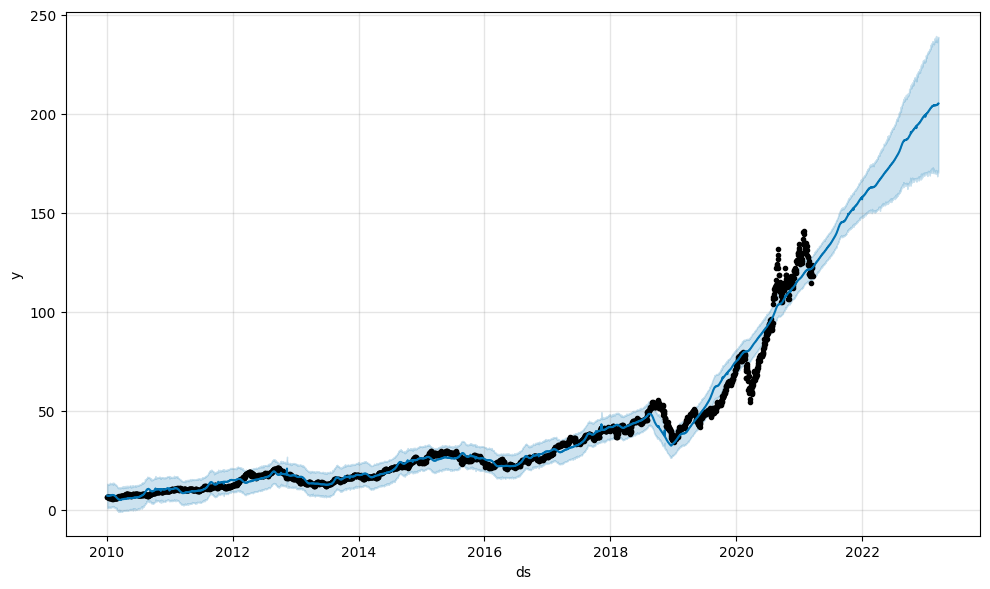

In [9]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly

def fetch_data(stock_symbol, start_date, end_date):
    """
    Fetch historical stock data from yfinance.
    """
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    return data

def preprocess_data(data):
    """
    Preprocess the data for Prophet model.
    """
    df = data.reset_index()
    df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)
    return df[['ds', 'y']]

class StockPredictor:
    def __init__(self, stock_symbol, start_date, end_date, periods=365, split_ratio=0.8):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.periods = periods
        self.split_ratio = split_ratio
        self.model = None
        self.forecast = None

        self.load_and_preprocess_data()
        self.split_data()
        self.train_prophet_model()

    def load_and_preprocess_data(self):
        stock_data = fetch_data(self.stock_symbol, self.start_date, self.end_date)
        self.data = preprocess_data(stock_data)

    def split_data(self):
        train_size = int(self.split_ratio * len(self.data))
        self.train_data = self.data[:train_size]
        self.test_data = self.data[train_size:]

    def train_prophet_model(self):
        self.model = Prophet(
            changepoint_prior_scale=0.05,
            holidays_prior_scale=15,
            seasonality_prior_scale=10,
            weekly_seasonality=True,
            yearly_seasonality=True,
            daily_seasonality=False
        )
        self.model.add_country_holidays(country_name='US')
        self.model.fit(self.train_data)

    def generate_forecast(self, on_test_data=False):
        if on_test_data:
            future = pd.DataFrame(self.test_data['ds'])
        else:
            future = self.model.make_future_dataframe(periods=self.periods)
        self.forecast = self.model.predict(future)

    def plot_forecast(self):
        fig = self.model.plot(self.forecast)
        plt.show()

    def plot_components(self):
        return plot_components_plotly(self.model, self.forecast)

    def calculate_mape(self, actual, predicted):
        actual, predicted = np.array(actual), np.array(predicted)
        return np.mean(np.abs((actual - predicted) / actual)) * 100

    def evaluate_model(self):
        self.generate_forecast(on_test_data=True)
        predictions = self.forecast.tail(len(self.test_data))['yhat']
        mape = self.calculate_mape(self.test_data['y'], predictions)
        return mape


# Example usage:
stock_symbol = 'AAPL'  # Apple Inc.
start_date = '2010-01-01'
end_date = '2025-01-01'
predictor = StockPredictor(stock_symbol, start_date, end_date, periods=730)

# Generate and plot forecast
predictor.generate_forecast()
predictor.plot_forecast()

# Plot components
predictor.plot_components()


In [10]:

# Evaluate model accuracy
mape_value = predictor.evaluate_model()
print(f"Model MAPE: {mape_value}%")
# mean absolute percentage error (MAPE)

Model MAPE: 17.982246441714416%
